In this notebook
1) Get data \
    1.1) Read HDF5 \
    1.2) Select only I channel 
2) Filter with moving average
3) Cut data (discard baseline tale) 
4) Filter data (movinga average)
5) Compute second derivative
6) Get cuspid point on x-axis
7) Select 1/8 of total signal lenght for pre trigger

In [185]:
import h5py
import os
import sys
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT')
from HDF5 import HDF5
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit

In [186]:
def read(parent):
    data = []
    counter = 0
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith('.hdf5') and counter<10:
                file_path = os.path.join(root, file)
                f = HDF5.HDF5()
                f.name = file_path
                data.append(f.load_hdf5()['Signals']['I'])
                counter = counter + 1
                print(f'reading file : {counter}')
    return data


In [187]:
data = read(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\RUNS\10')

Execution time: 0.172
reading file : 1
Execution time: 0.228
reading file : 2
Execution time: 0.169
reading file : 3
Execution time: 0.189
reading file : 4
Execution time: 0.194
reading file : 5
Execution time: 0.177
reading file : 6
Execution time: 0.184
reading file : 7
Execution time: 0.175
reading file : 8
Execution time: 0.182
reading file : 9
Execution time: 0.163
reading file : 10


In [188]:
xmin, ymin = [np.argmin(data[0]) , min(data[0])]

In [189]:
#idx = [i for i in range(len(data[1])) if (i<int(0.3*1e6) and i>int(0.15*1e6))]
#I = data[1][idx]

I = data[0][xmin-3000:xmin+10000]
T = np.linspace(xmin-3000,xmin+10000,len(I),dtype=int)

In [190]:
# Apply moving average filter
window_size = 50  # Size of the moving average window
cumsum = np.cumsum(I)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size
# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))

In [191]:
window_length = 171  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(moving_avg, window_length, polyorder)

# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

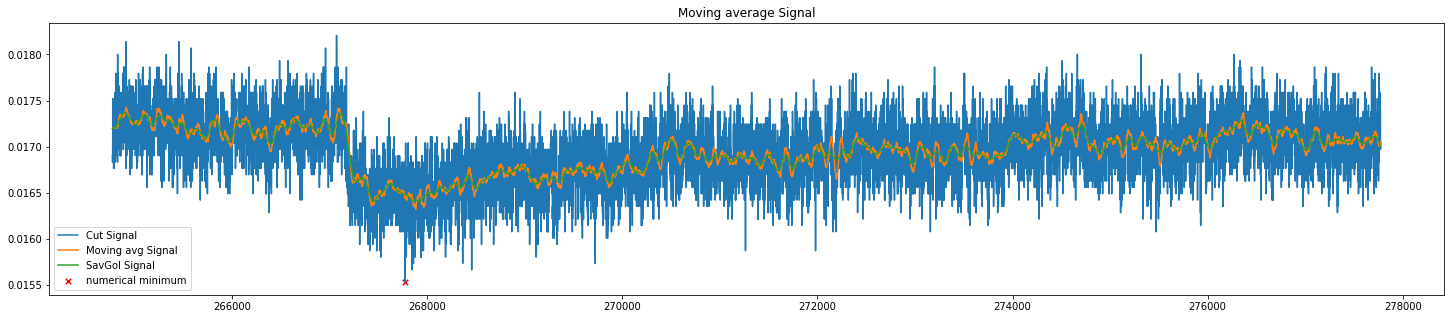

In [194]:
plt.figure(figsize=(25,5))
plt.plot(T, I, label='Cut Signal')
plt.plot(T, moving_avg, label='Moving avg Signal')
plt.plot(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal')
plt.scatter(xmin, ymin, marker='x',color='red',s=30,label='numerical minimum')
plt.title('Moving average Signal')
plt.legend()

In [195]:
len_fit = int(np.floor(len(I)/10))
pol_amp = np.polyfit(T[:len_fit], I[:len_fit], 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, T[:len_fit])-I[:len_fit])**2))   

In [196]:
def model(x, A,B,C,D):
    return A*np.exp(-B*(x-C))+D

def sigmoid(x, A, B, C, D):
    return A / (1.0 + np.exp(-B * (x - C))) + D

In [216]:
p0 = [14,0.00046,180322,-0.0172]
p0_sig = [0.0006,0.1,267200,-0.0172]

In [217]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [238]:
sig = LeastSquares(T[2000:3200],-smoothed_signal[2000:3200],rms,sigmoid)
exp = LeastSquares(T[3200:len(smoothed_signal)],-smoothed_signal[3200:len(smoothed_signal)],rms,model)
msig = Minuit(sig,*p0_sig)
mexp = Minuit(exp,*p0)
msig.migrad(iterate=1000)

C:\Users\kid\AppData\Local\Temp\ipykernel_7232\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 81.15 (χ²/ndof = 0.1)      │              Nfcn = 265              │
│ EDM = 2.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ 0.731e-3  │ 0.018e-3  │            │            │         │         │       │
│ 1 │ B    │   0.039   │   0.008   │            │            │         │         │       │
│ 2 │ C    │ 267.215e3 │  0.006e3  │            │            │         │         │       │
│ 3 │ D    │-17.236e-3 │ 0.014e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────────┐
│   │           A           B           C           D │
├───┼─────────────────────────────────────────────────┤
│ A │    3.29e-10   -48.49e-9  6.99475e-6    -0.20e-9 │
│ B │   -48.49e-9    5.89e-05   -19.66e-3    18.65e-9 │
│ C │  6.99475e-6   -19.66e-3        30.7 14.27713e-6 │
│ D │    -0.20e-9    18.65e-9 14.27713e-6    1.98e-10 │
└───┴─────────────────────────────────────────────────┘

In [239]:
mexp.migrad(iterate=1000)

C:\Users\kid\AppData\Local\Temp\ipykernel_7232\1250387595.py:2: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-B*(x-C))+D


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 817 (χ²/ndof = 0.1)        │              Nfcn = 536              │
│ EDM = 2.44e-06 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │    156    │    19     │            │            │         │         │       │
│ 1 │ B    │ 229.9e-6  │  2.1e-6   │            │            │         │         │       │
│ 2 │ C    │  213.9e3  │   0.5e3   │            │            │         │         │       │
│ 3 │ D    │-17.173e-3 │ 0.006e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────────────────┐
│   │             A             B             C             D │
├───┼─────────────────────────────────────────────────────────┤
│ A │           351  17.644688e-6       -5.61e3  13.445571e-6 │
│ B │  17.644688e-6      4.34e-12 507.277113e-6         5e-12 │
│ C │       -5.61e3 507.277113e-6      2.76e+05 386.559770e-6 │
│ D │  13.445571e-6         5e-12 386.559770e-6      3.09e-11 │
└───┴─────────────────────────────────────────────────────────┘

Text(0.5, 1.0, 'Time constant FIT')

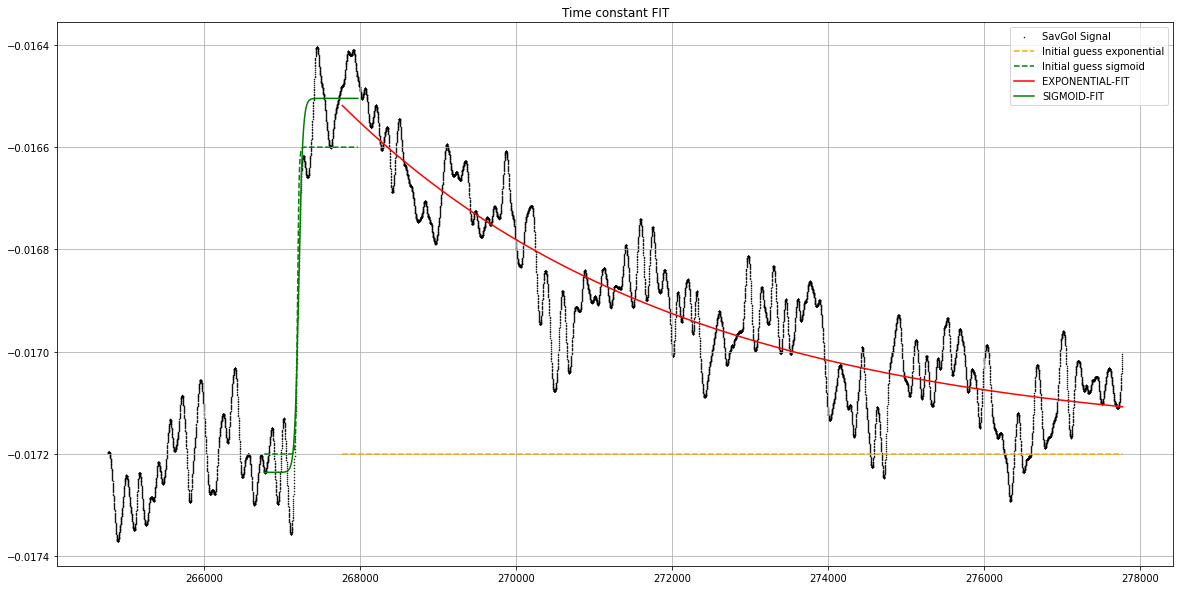

In [240]:
plt.figure(figsize=(20,10))
plt.scatter(T[:len(smoothed_signal)], -smoothed_signal, label='SavGol Signal',marker='.',s=1,color='black')
plt.plot(T[3000:13000],model(T[3000:13000],*p0),label='Initial guess exponential',linestyle='--',color='orange')
plt.plot(T[2000:3200],sigmoid(T[2000:3200],*p0_sig),label='Initial guess sigmoid',linestyle='--',color='green')
plt.plot(T[3000:13000],model(T[3000:13000],*mexp.values),label='EXPONENTIAL-FIT',linestyle='-',color='red')
plt.plot(T[2000:3200],sigmoid(T[2000:3200],*msig.values),label='SIGMOID-FIT',linestyle='-',color='green')
plt.legend()
plt.grid()
plt.title('Time constant FIT')

In [241]:
mexp.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,A,156,19,,,,,
1,B,229.9e-6,2.1e-6,,,,,
2,C,213.9e3,0.5e3,,,,,
3,D,-17.173e-3,0.006e-3,,,,,


In [242]:
msig.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,A,0.731e-3,0.018e-3,,,,,
1,B,0.039,0.008,,,,,
2,C,267.215e3,0.006e3,,,,,
3,D,-17.236e-3,0.014e-3,,,,,


In [243]:
# Calculate the 10% and 90% points of the fitted signal
y_10 = msig.values['D'] + 0.1 * msig.values['A']
y_90 = msig.values['D'] + 0.9 * msig.values['A']

# Find the time at which the signal reaches these values
t_10 = T[np.abs(sigmoid(T[2000:3200],*msig.values) - y_10).argmin()]
t_90 = T[np.abs(sigmoid(T[2000:3200],*msig.values) - y_90).argmin()]

# Calculate the rise time
rise_time = (t_90 - t_10)*1e-8
print(f"Rise Time: {rise_time*1e6:.4f} micro seconds")

Rise Time: 1.1300 micro seconds


In [244]:
fitted_signal = np.array(list(sigmoid(T[0:3000],*msig.values))+list(model(T[3000:],*mexp.values)))

In [245]:
window = 111 
polyorder = 3 
fd = savgol_filter(fitted_signal,window, polyorder, deriv=1) 
sd = savgol_filter(fitted_signal,window, polyorder, deriv=2) 

In [246]:
th = 4*1e-8
peaks, props = find_peaks(sd, th)
peak = peaks[np.argmax(props['peak_heights'])]

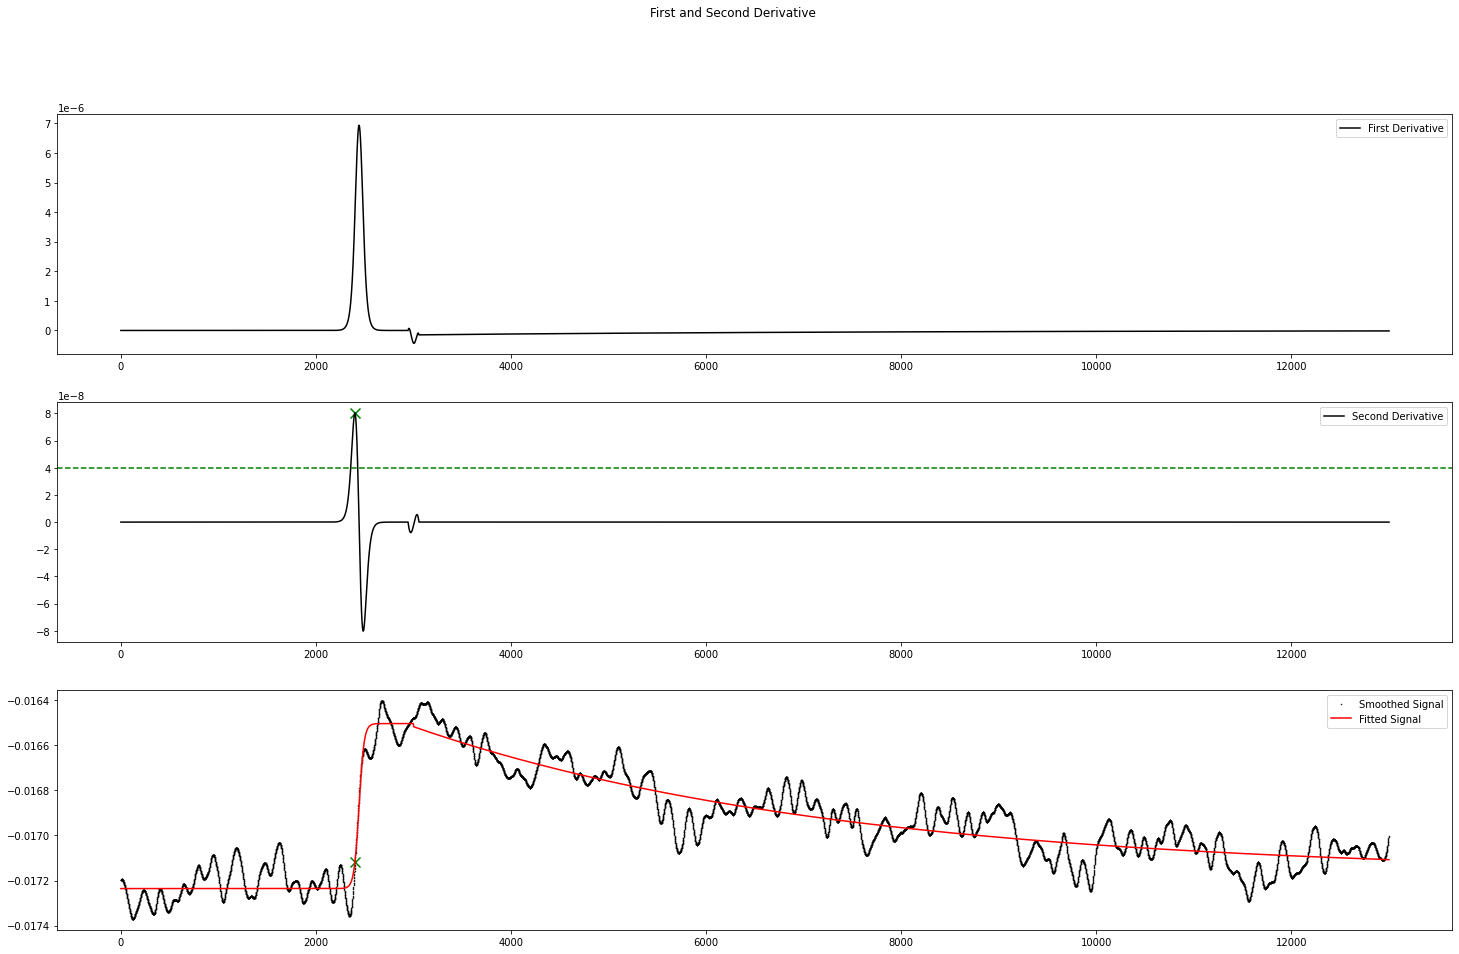

In [247]:
fig, axs = plt.subplots(3,1,figsize=(25,15))
axs[1].plot(np.linspace(0,len(sd),len(sd)),sd,color='black',label='Second Derivative')
axs[0].plot(np.linspace(0,len(fd),len(fd)),fd,color='black',label='First Derivative')
#axs[0].axhline(th, 0, 1, linestyle='--', color='green')
axs[2].scatter(np.linspace(0,len(-smoothed_signal),len(-smoothed_signal)), -smoothed_signal, label='Smoothed Signal',marker='.',color='black',s=1)
axs[2].plot(np.linspace(0,len(fitted_signal),len(fitted_signal)), fitted_signal, label='Fitted Signal',color='red')
axs[1].scatter(peak, max(props['peak_heights']), marker='x', color='green', s=100)
axs[2].scatter(peak, fitted_signal[peak], marker='x', color='green', s=100)
axs[1].axhline(th, 0, 1, linestyle='--', color='green')
fig.suptitle('First and Second Derivative')
axs[0].legend()
axs[1].legend()
axs[2].legend()

In [248]:
with open('Trigger.txt','a') as file:
    file.writelines('\n'+str(peaks[0])+'\t'+str(props['peak_heights'][0]))